In [1]:
# Установка необходимых библиотек
!pip install transformers[torch]
!pip install datasets
!pip install torch
!pip install accelerate -U
!pip install evaluate

# Монтирование Google Диска
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from evaluate import load as evaluate_load
from tqdm.notebook import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
# Загрузка датасета
df = pd.read_parquet('/content/drive/MyDrive/dataset.parquet')

In [11]:
# Разделение датасета на обучающую и тестовую выборки
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [12]:
# Класс для обработки датасета
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

In [ ]:
# Загрузка токенизатора и модели
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# продолжить с чекпоинта
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Укажите путь к чекпоинту
checkpoint_path = '/content/drive/MyDrive/checkpoint/checkpoint-29500'

# Загрузите модель из чекпоинта
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [13]:
# Параметры обучения
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/checkpoint',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/log',
    logging_steps=10,
    eval_strategy="epoch"
)

In [14]:
# Подготовка датасетов
train_dataset = TextDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer, max_length=128)
test_dataset = TextDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer, max_length=128)

In [15]:
# Функция для оценки метрик
def compute_metrics(p):
    metric = evaluate_load("accuracy")
    logits, labels = p
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return metric.compute(predictions=predictions, references=torch.tensor(labels))

In [16]:
# Создание объекта Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Обучение модели
train_result = trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.596300,0.819368,0.722700
2,0.800600,0.791969,0.737000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.596300,0.819368,0.722700
2,0.800600,0.791969,0.737000
3,0.643800,0.819415,0.749850


In [ ]:
train_result = trainer.train(resume_from_checkpoint=checkpoint_path)
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy
3,0.643800,0.819415,0.749850


In [ ]:
# Оценка модели
results = trainer.evaluate()
print(results)

{'eval_loss': 0.8194148540496826, 'eval_accuracy': 0.74985, 'eval_runtime': 176.8766, 'eval_samples_per_second': 113.073, 'eval_steps_per_second': 14.134, 'epoch': 3.0}


Проверка

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

checkpoint_path = '/content/drive/MyDrive/checkpoint/checkpoint-30000'
model = RobertaForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def predict(text, model, tokenizer):
    # Токенизация текста
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)

    # Прогнозирование
    with torch.no_grad():
        outputs = model(**inputs)

    # Получение предсказанных меток
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1).item()

    return predicted_class_id

In [ ]:
# Пример текста для тестирования
sample_text = "If I go home my dog will still be dead. I’ll still be a terrible mother. My husband will still think I’m useless. Wish I could disappear."

# Предсказание метки для нового текста
predicted_label = predict(sample_text, model, tokenizer)
print(f"Predicted label: {predicted_label}")

Predicted label: 2


строка из конца датасета, которая не попала в обучение:

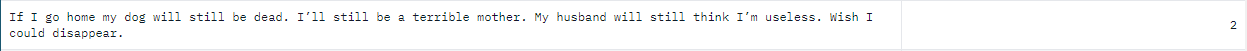

Дополнительные метрики:

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer

In [33]:
# Оценка модели
predictions = trainer.predict(test_dataset)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    # Матрица ошибок
    cm = confusion_matrix(labels, preds)

    # Отчет о классификации
    report = classification_report(labels, preds, output_dict=True)

    return cm, report

cm, report = compute_metrics(predictions)

In [34]:
# Преобразование отчета в DataFrame для удобного отображения
report_df = pd.DataFrame(report).transpose()

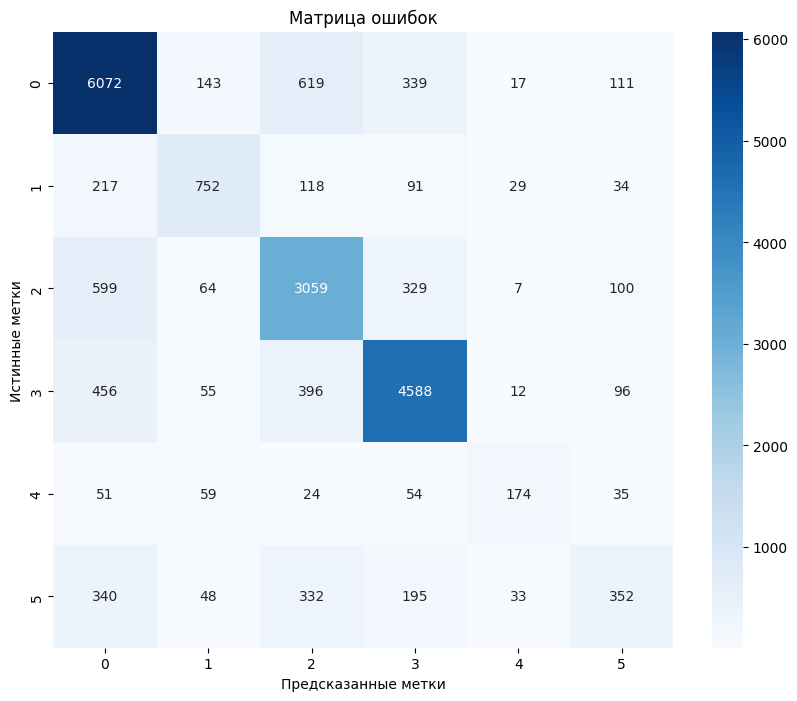

In [35]:
# Построение матрицы ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

In [36]:
# Печать отчета о классификации
print(report_df)

              precision    recall  f1-score      support
0              0.785003  0.831667  0.807662   7301.00000
1              0.670830  0.605963  0.636749   1241.00000
2              0.672603  0.735690  0.702734   4158.00000
3              0.819871  0.818847  0.819359   5603.00000
4              0.639706  0.438287  0.520179    397.00000
5              0.483516  0.270769  0.347140   1300.00000
accuracy       0.749850  0.749850  0.749850      0.74985
macro avg      0.678588  0.616871  0.638970  20000.00000
weighted avg   0.741838  0.749850  0.742879  20000.00000


In [40]:
# Анализ датасета
df = pd.read_parquet('/content/drive/MyDrive/dataset.parquet')

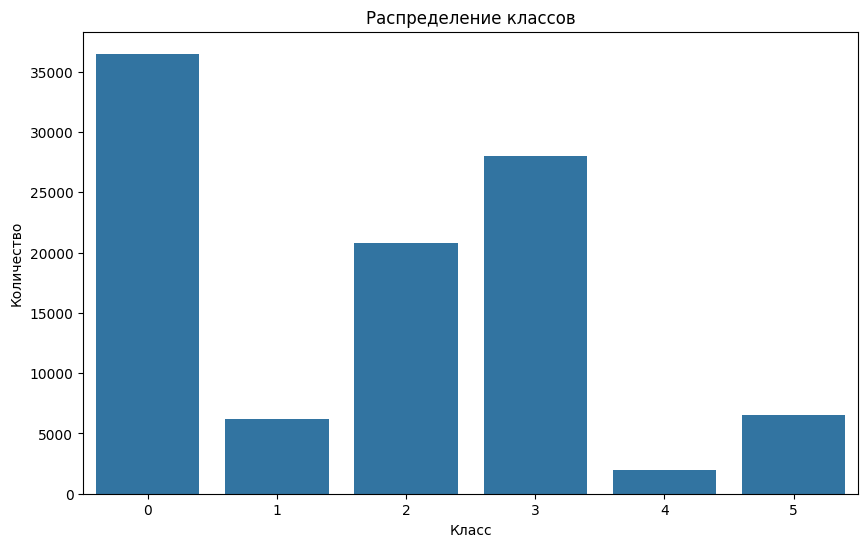

In [39]:
# Распределение классов
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов')
plt.show()

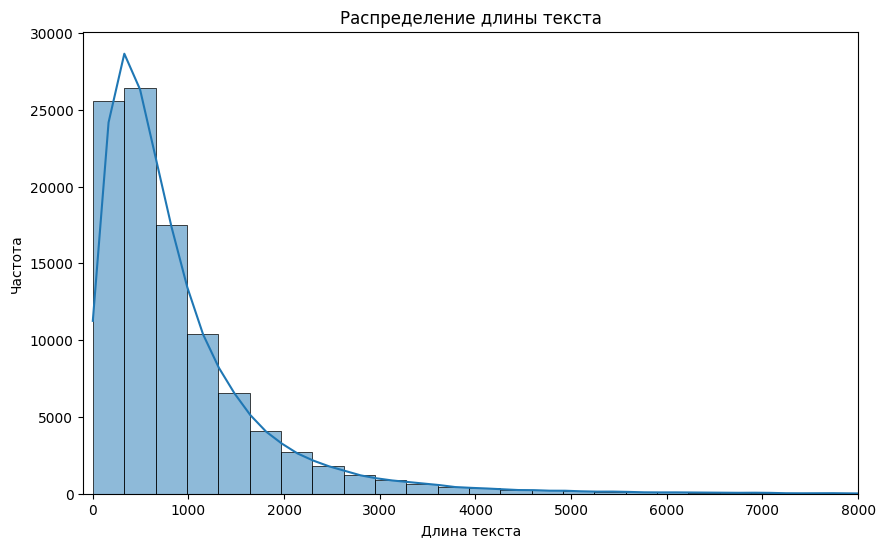

In [30]:
# Длина текстов
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=100, kde=True)
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.title('Распределение длины текста')
plt.xlim(-100, 8000)
plt.show()

Сохранение модели и токенизатора

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Путь для сохранения модели и токенизатора
save_directory = "/content/drive/MyDrive/saved_model"

# Сохранение модели и токенизатора
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_model/vocab.json',
 '/content/drive/MyDrive/saved_model/merges.txt',
 '/content/drive/MyDrive/saved_model/added_tokens.json')